In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
import statsmodels

In [51]:
df = pd.read_excel("System_combined.xlsx")
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df = df.drop("Unnamed: 0", axis = 1)
df['systemPrice'].interpolate(method='time', inplace=True)
df.isna().sum()


systemPrice    0
dtype: int64

## Tests for stationarity 

In [3]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print('Results of Augmented Dickey-Fuller Test:')
    adf_result = adfuller(timeseries)
    
    # Retrieve the p-value
    adf_pvalue = adf_result[1]
    
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_pvalue}')
    
    if adf_pvalue < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print('\nResults of KPSS Test:')
    statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    
    # As the p-value is approximate, it should not be taken as an absolute measure of stationarity.
    if p_value < 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")



In [4]:

adf_test(df["systemPrice"]) #h0 can be rejected, there is  enough evidence that the timeseries is stationary
kpss_test(df["systemPrice"]) #h0 can be rejected, there is enough evidence that the timeseries is non-statinoary

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -9.577550489049926
p-value: 2.2025769433108786e-16
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 8.876045258727991
p-value: 0.01
The series is non-stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_57016\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [52]:

df["systemPricead"] = df["systemPrice"] + 35
df["systemPricelog"] = np.log(df["systemPricead"])
df = df["2023-01-01":"2023-12-31"]



,systemPrice,systemPricead,systemPricelog
DateTime,,,
2023-01-01 00:00:00,23.374971,58.374971,4.066887
2023-01-01 01:00:00,21.639717,56.639717,4.036710
2023-01-01 02:00:00,16.006176,51.006176,3.931947
2023-01-01 03:00:00,11.428002,46.428002,3.837903
2023-01-01 04:00:00,4.637178,39.637178,3.679768
...,...,...,...
2023-12-31 19:00:00,49.594203,84.594203,4.437866
2023-12-31 20:00:00,44.985186,79.985186,4.381841
2023-12-31 21:00:00,44.755875,79.755875,4.378970


# Finding Parameters for ARIMA


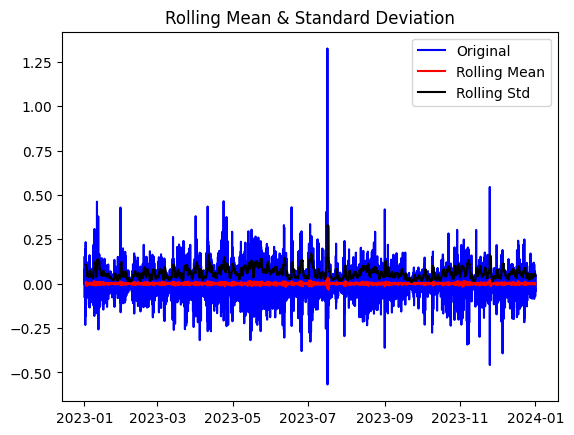

In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(df["systemPricelog"].diff().diff())
#adf_test(differenced_data)

In [6]:
import pandas as pd
from scipy import stats

# Assuming `df` is your DataFrame and it contains a column named 'value'
# which stores the time series data.

# Calculate the z-scores
df['z_score'] = stats.zscore(df['systemPricelog'])

# Filter out the outliers
threshold = 3
df_filtered = df[(df['z_score'] > -threshold) & (df['z_score'] < threshold)]

# Now df_filtered contains the original data without outliers.


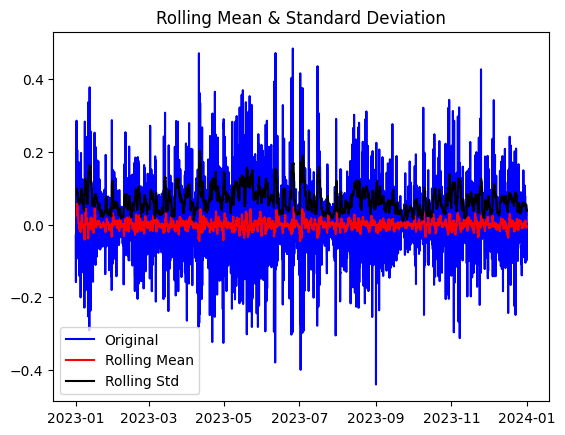

In [7]:
test_stationarity(df_filtered["systemPricelog"].diff().dropna())

In [20]:
adf_test(df_filtered["systemPricelog"].diff().dropna())
kpss_test(df_filtered["systemPricelog"].diff().dropna())

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -18.335945933379826
p-value: 2.2509838808301472e-30
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.0390993276488459
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_57016\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


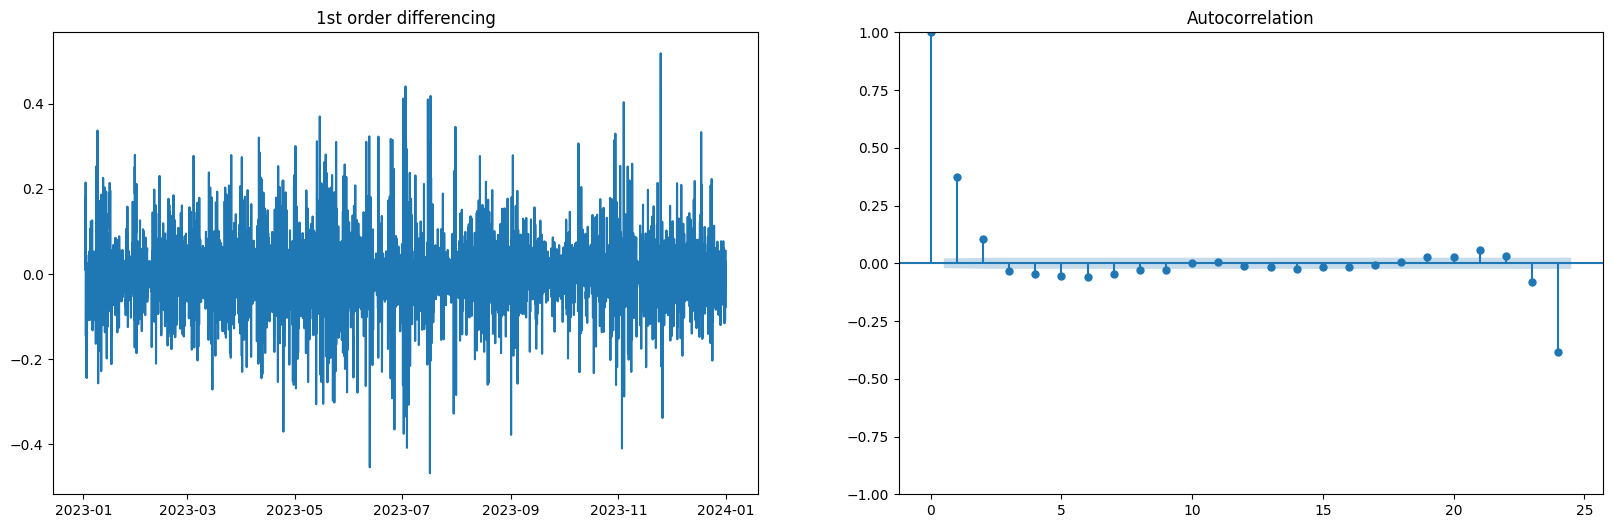

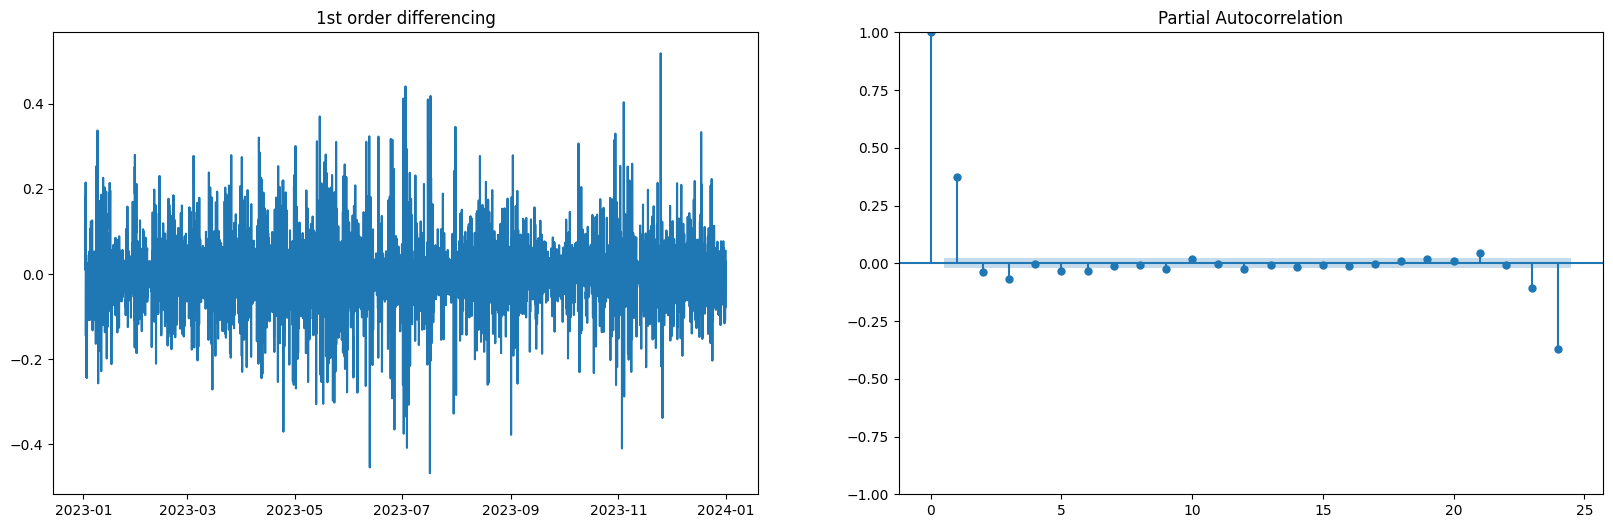

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -23.648761491743336
p-value: 0.0
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.002928921471837624
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_51156\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [104]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#filtered_df = df["2018-01-01":"2019-12-31"]
# Assuming df["systemPrice"] is your data series.
differenced_data = df_filtered["systemPricelog"].diff().diff(24).dropna()


# Set a wider figure size. For example, (20, 6) makes the figure 20 inches wide and 6 inches tall.
f = plt.figure(figsize=(20, 6))

# First subplot for the differenced data.
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

# Second subplot for the ACF plot.
ax2 = f.add_subplot(122)
plot_acf(differenced_data, lags=24, ax=ax2)
plt.show()

# Create another figure for the PACF plot, with the same figsize to keep consistency.
f = plt.figure(figsize=(20, 6))

ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

ax2 = f.add_subplot(122)
plot_pacf(differenced_data, lags=24, ax=ax2)
plt.show()

adf_test(differenced_data)
kpss_test(differenced_data)



## Trying to use the diff df and extracting seasonal component and trend being left with residuals

In [ ]:
# Re-importing the necessary libraries as the execution state was reset.
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

filtered_df = df["2023-01-01":"2023-12-31"]
decomposition = seasonal_decompose(filtered_df['systemPrice'], model='additive', period=24)

# This will extract the trend, seasonal, and residual components.
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition.plot()

# Show the plots
plt.show()

# Calculate rolling statistics
window = 24  # can be adjusted based on the dataset
rolmean = residual.rolling(window).mean()
rolstd = residual.rolling(window).std()

# Create a figure for the residuals and their rolling statistics
f = plt.figure(figsize=(20, 10))

ax1 = f.add_subplot(211)
ax1.set_title("Residuals with rolling mean and standard deviation")
ax1.plot(residual.dropna(), label='Original Residuals')
ax1.plot(rolmean, label='Rolling Mean', color= "red")
ax1.plot(rolstd, label='Rolling Std')
ax1.legend()

# Second subplot for the ACF plot.
ax2 = f.add_subplot(212)
plot_acf(residual.dropna(), lags=168, ax=ax2)





In [ ]:
#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_acf(residual.dropna(), ax=ax2)
#plt.show()


#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("Residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_pacf(residual.dropna(), ax=ax2)
#plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_acf(residual.diff().dropna(), ax=ax2)
plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_pacf(residual.diff().dropna(), ax=ax2)
plt.show()



In [ ]:
adf_test(residual.dropna())
kpss_test(residual.dropna()) 


# ARIMA New

In [ ]:

# Using the to_frame() method
df = filtered_dfArima["systemPrice"].to_frame()

# Alternatively, using the DataFrame constructor
df = pd.DataFrame(filtered_dfArima["systemPrice"])
df.info()
# Using the to_frame() method

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         systemPricelog   No. Observations:                 8732
Model:                 ARIMA(1, 1, 3)   Log Likelihood               11713.560
Date:                Tue, 02 Apr 2024   AIC                         -23417.119
Time:                        13:30:20   BIC                         -23381.746
Sample:                             0   HQIC                        -23405.064
                               - 8732                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9314      0.004    252.833      0.000       0.924       0.939
ma.L1         -0.5805      0.009    -68.248      0.000      -0.597      -0.564
ma.L2         -0.2448      0.010    -24.929      0.0

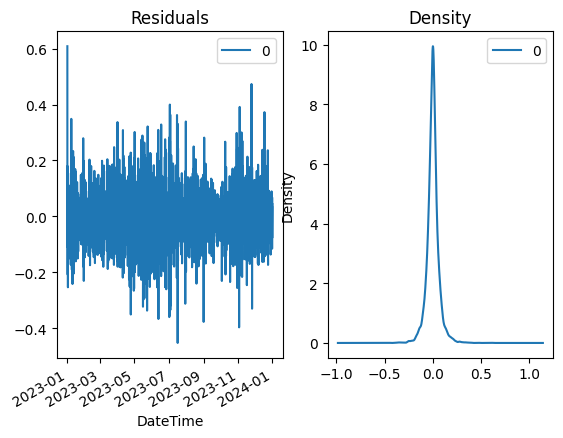

In [8]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt




# Choose the section of the dataframe that you want to model
#filtered_df = df["2023-6-01":"2023-12-01"]

# ARIMA Model parameters (p, d, q)
# These should be chosen based on your prior analysis, ACF, PACF, and stationarity tests
p = 1  # Replace with your chosen value
d =  1 # Replace with your chosen value, based on your earlier statement that no differencing is needed
q = 3  # Replace with your chosen value

# Fit the ARIMA model
model = ARIMA(df_filtered["systemPricelog"].diff(24).dropna(), order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()




In [9]:

train_size = int(len(df_filtered["systemPricelog"]) * 0.8)
train, test = df_filtered["systemPricelog"][0:train_size], df_filtered["systemPricelog"][train_size:len(df_filtered["systemPricelog"])]


In [18]:
train

DateTime
2023-01-01 00:00:00    4.066887
2023-01-01 01:00:00    4.036710
2023-01-01 02:00:00    3.931947
2023-01-01 03:00:00    3.837903
2023-01-01 04:00:00    3.679768
                         ...   
2023-10-19 19:00:00    3.846674
2023-10-19 20:00:00    3.794034
2023-10-19 21:00:00    3.790194
2023-10-19 22:00:00    3.770336
2023-10-19 23:00:00    3.752187
Name: systemPricelog, Length: 7004, dtype: float64

## Working ARIMA, SUS

In [69]:
df = pd.read_excel("System_combined.xlsx")
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df = df.drop("Unnamed: 0", axis = 1)
df['systemPrice'].interpolate(method='time', inplace=True)
df.isna().sum()

systemPrice    0
dtype: int64

Log transforming

In [70]:
df["systemPriceadd"] = df["systemPrice"] + 35
df["systemPriceLog"] = np.log(df["systemPriceadd"])


In [71]:

train_size = int(len(df_filtered["systemPricelog"]) * 0.8)
train, test = df_filtered["systemPricelog"][0:train_size], df_filtered["systemPricelog"][train_size:len(df_filtered["systemPricelog"])]

In [86]:
df_filtered = df_filtered["2023-01-01":"2023-12-31"]

In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
filtered_dfArima = df_filtered["systemPricelog"].dropna()
window_size = 48  # Size of the moving window #Best 48

# Make sure to have enough data for the initial window plus one new point to predict
assert len(filtered_dfArima) >= window_size + 1

# Start the training set just with the size of the window
#train, test = filtered_dfArima[:window_size], filtered_dfArima[window_size:]

order = (1, 2, 1)  # Example non-seasonal order #best: 1,2,1
seasonal_order = (1, 2, 1, 24)  # Example seasonal order #Best 1,2,1,24

history = train.tolist()  # Initialize history with the training set
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    # Forecasted value in log scale
    yhat_log = output[0]
    # Convert from log scale back to original scale
    yhat_original = np.exp(yhat_log) - 35
    predictions.append(yhat_original)
    
    # Append the observed log-transformed value to history for the next prediction
    history.append(test.iloc[t])  
    history = history[-window_size:]  # Keep only the most recent observations


# Convert predictions to a Series
predictions_series = pd.Series(predictions, index=test.index)


#88min 22.3s all years
#47min 2022-2023

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 24)   Log Likelihood                   0.000
Date:                            Tue, 02 Apr 2024   AIC                             10.000
Time:                                    20:26:06   BIC                                nan
Sample:                                         0   HQIC                               nan
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'pyplot' is not defined

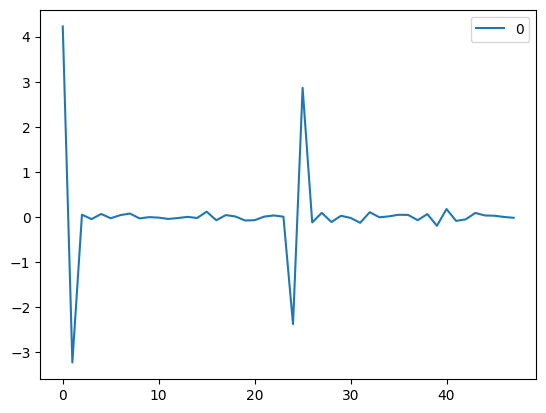

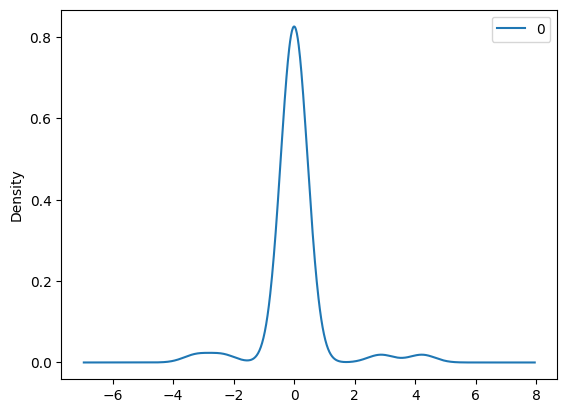

In [125]:
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

residuals.plot(kind = "kde")
pyplot.show()

In [131]:
# evaluate an ARIMA model using a walk-forward validation


from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt




In [ ]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

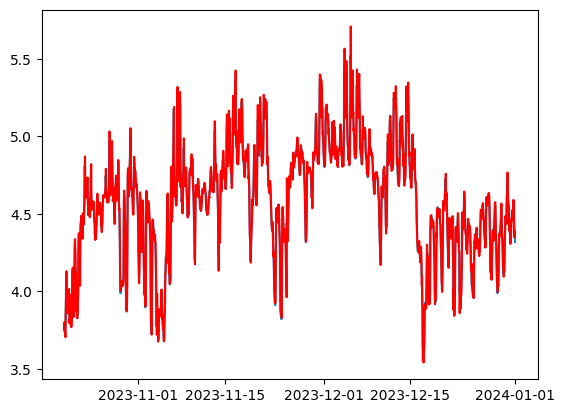

Test RMSE: 0.056
RMSE for the first 24 hours: 2.089516295524222
MAE for the first 24 hours: 1.4715440279728043


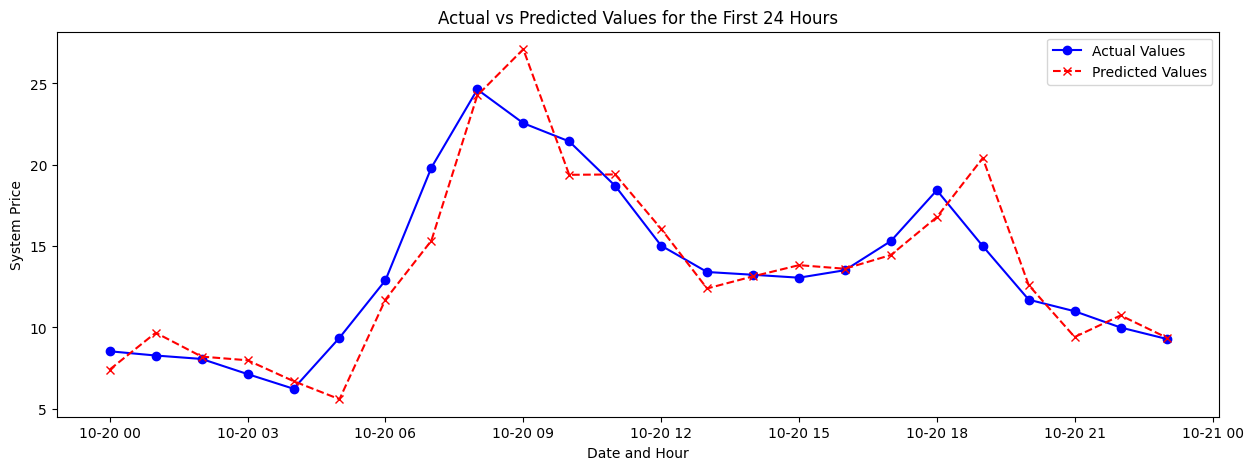

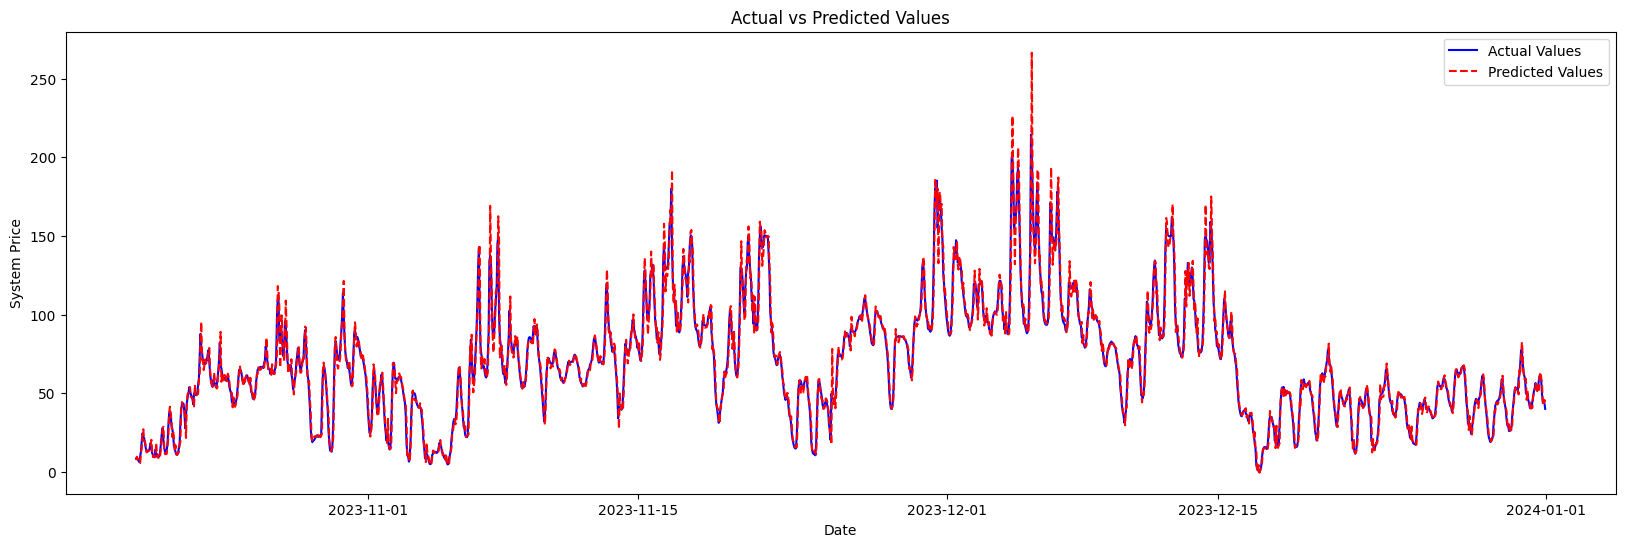

In [175]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


# Compute the RMSE and MAE for the first 24 hours
actual_first_24 = np.exp(test.iloc[:24])-35  # Assuming 'test' is the log of (price + 35)
predicted_first_24 = np.exp(predictions.iloc[:24]) -35

rmse = np.sqrt(mean_squared_error(actual_first_24, predicted_first_24))
mae = mean_absolute_error(actual_first_24, predicted_first_24)

# Print the performance metrics
print(f"RMSE for the first 24 hours: {rmse}")
print(f"MAE for the first 24 hours: {mae}")

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(actual_first_24.index, actual_first_24, marker='o', color='blue', label='Actual Values')
plt.plot(predicted_first_24.index, predicted_first_24, marker='x', linestyle='--', color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values for the First 24 Hours')
plt.xlabel('Date and Hour')
plt.ylabel('System Price')
plt.legend()
plt.show()


actual_values =  np.exp(test) - 35
predictions_series = np.exp(predictions) - 35 # Assuming `test` is already in log scale
# Ensure that the index of actual values and predictions aligns for correct plotting
assert actual_values.index.equals(predictions_series.index)

# Plotting
plt.figure(figsize=(20, 6))  # Set the figure size for better readability
plt.plot(actual_values.index, actual_values, color='blue', label='Actual Values')  # Plot actual values in blue
plt.plot(predictions_series.index, predictions_series, color='red', linestyle='--', label='Predicted Values')  # Plot predicted values in red with dashed lines
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('System Price')
plt.legend()

In [161]:
import pandas as pd


# Convert 'predictions' to a pandas Series (if it's not already a DataFrame).
predictions = pd.Series(predictions, name='Predictions')

# Assign the datetime index from 'test' to 'predictions_series'.
predictions.index = test.index

# Now 'predictions_series' is aligned with 'test'.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8755
Model:                 ARIMA(5, 1, 0)   Log Likelihood               12773.580
Date:                Tue, 02 Apr 2024   AIC                         -25535.161
Time:                        21:54:28   BIC                         -25492.697
Sample:                             0   HQIC                        -25520.691
                               - 8755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6249      0.006     98.590      0.000       0.613       0.637
ar.L2         -0.0230      0.009     -2.508      0.012      -0.041      -0.005
ar.L3         -0.1266      0.011    -11.382      0.0

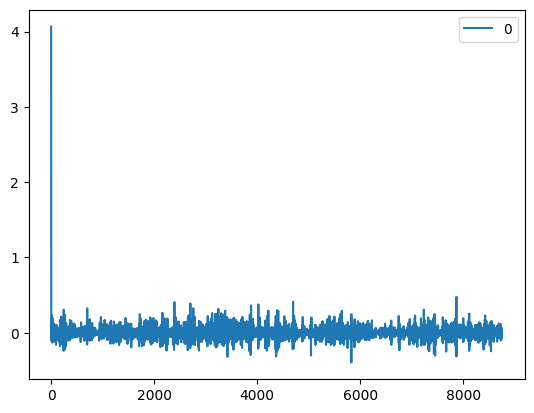

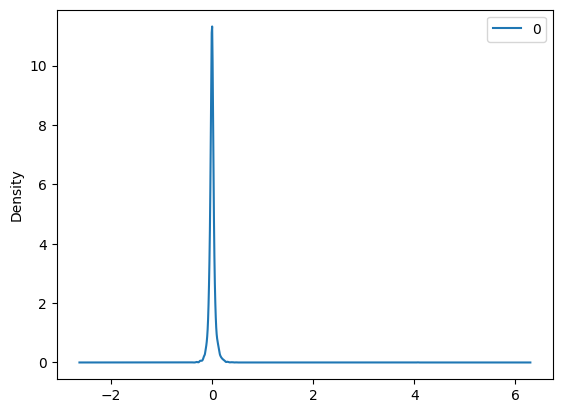

In [171]:
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

residuals.plot(kind = "kde")
pyplot.show()

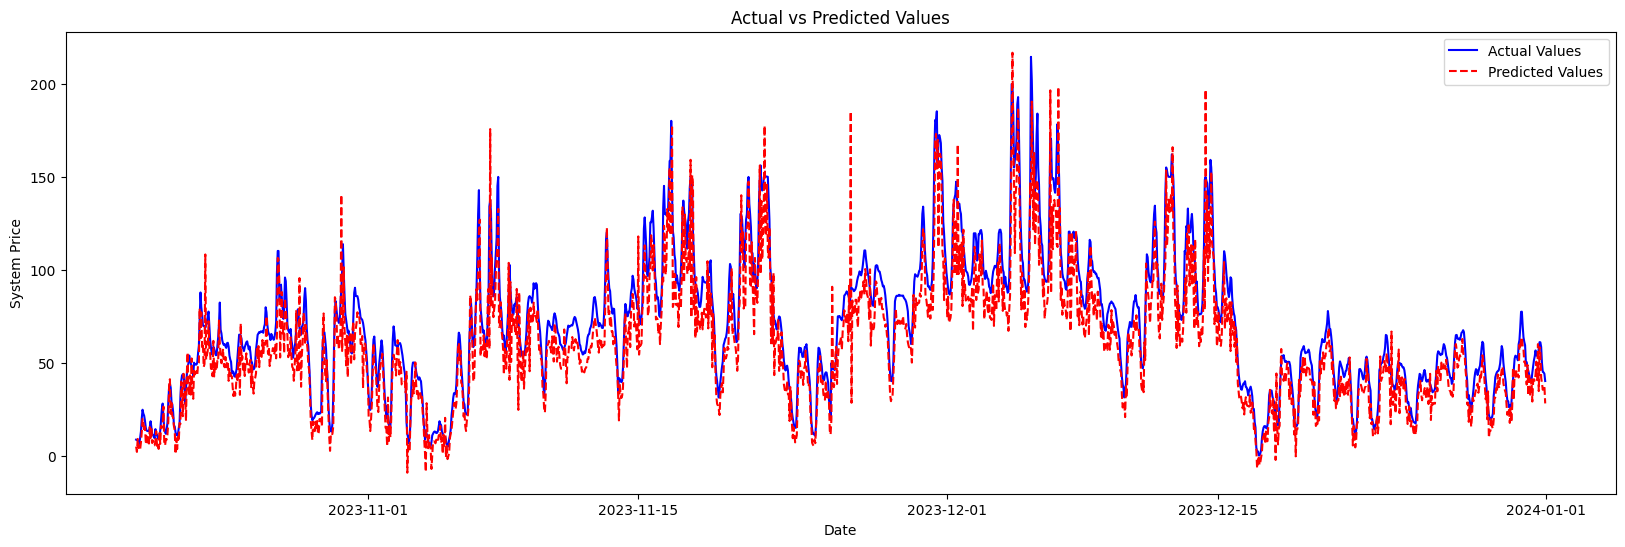

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Reverse the log transformation on the actual values

actual_values = np.exp(test) - 35 # Assuming `test` is already in log scale
# Ensure that the index of actual values and predictions aligns for correct plotting
assert actual_values.index.equals(predictions_series.index)

# Plotting
plt.figure(figsize=(20, 6))  # Set the figure size for better readability
plt.plot(actual_values.index, actual_values, color='blue', label='Actual Values')  # Plot actual values in blue
plt.plot(predictions_series.index, predictions_series, color='red', linestyle='--', label='Predicted Values')  # Plot predicted values in red with dashed lines
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('System Price')
plt.legend()
plt.show()



In [110]:
test

DateTime
2023-10-20 00:00:00    3.773607
2023-10-20 01:00:00    3.767613
2023-10-20 02:00:00    3.762736
2023-10-20 03:00:00    3.740890
2023-10-20 04:00:00    3.719271
                         ...   
2023-12-31 19:00:00    4.437866
2023-12-31 20:00:00    4.381841
2023-12-31 21:00:00    4.378970
2023-12-31 22:00:00    4.369272
2023-12-31 23:00:00    4.318659
Name: systemPricelog, Length: 1752, dtype: float64

In [111]:
actual_values

DateTime
2023-10-20 00:00:00     8.536806
2023-10-20 01:00:00     8.276652
2023-10-20 02:00:00     8.066115
2023-10-20 03:00:00     7.135461
2023-10-20 04:00:00     6.234309
                         ...    
2023-12-31 19:00:00    49.594203
2023-12-31 20:00:00    44.985186
2023-12-31 21:00:00    44.755875
2023-12-31 22:00:00    43.986141
2023-12-31 23:00:00    40.087854
Name: systemPricelog, Length: 1752, dtype: float64

In [101]:
#np.exp(test) - 35
predictions_series

DateTime
2023-10-20 00:00:00       7.222922
2023-10-20 01:00:00     290.458239
2023-10-20 02:00:00     276.372652
2023-10-20 03:00:00     275.691855
2023-10-20 04:00:00     272.393092
                          ...     
2023-12-31 19:00:00    1095.474842
2023-12-31 20:00:00     896.739937
2023-12-31 21:00:00     872.936685
2023-12-31 22:00:00     888.095709
2023-12-31 23:00:00     848.173849
Length: 1752, dtype: float64

## 24 Hour performance

In [97]:
df["2023-10-20":"2023-12-31"]

,systemPrice,systemPriceadd,systemPriceLog
DateTime,,,
2023-10-20 00:00:00,8.536806,43.536806,3.773607
2023-10-20 01:00:00,8.276652,43.276652,3.767613
2023-10-20 02:00:00,8.066115,43.066115,3.762736
2023-10-20 03:00:00,7.135461,42.135461,3.740890
2023-10-20 04:00:00,6.234309,41.234309,3.719271
...,...,...,...
2023-12-31 19:00:00,49.594203,84.594203,4.437866
2023-12-31 20:00:00,44.985186,79.985186,4.381841
2023-12-31 21:00:00,44.755875,79.755875,4.378970


RMSE for the first 24 hours: 5.285842197392629
MAE for the first 24 hours: 4.617488383363585


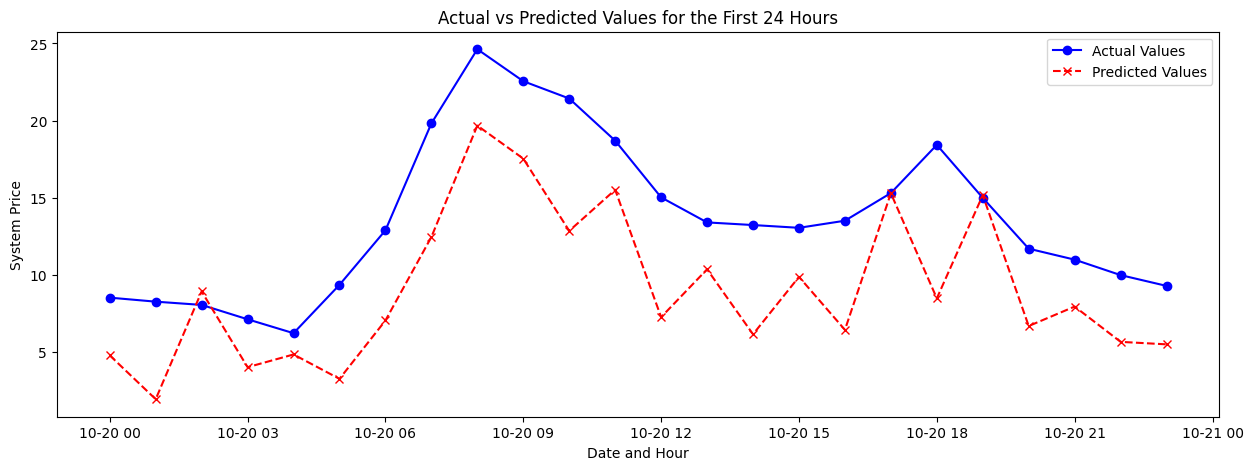

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute the RMSE and MAE for the first 24 hours
actual_first_24 = np.exp(test.iloc[:24])-35  # Assuming 'test' is the log of (price + 35)
predicted_first_24 = predictions_series.iloc[:24]

rmse = np.sqrt(mean_squared_error(actual_first_24, predicted_first_24))
mae = mean_absolute_error(actual_first_24, predicted_first_24)

# Print the performance metrics
print(f"RMSE for the first 24 hours: {rmse}")
print(f"MAE for the first 24 hours: {mae}")

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(actual_first_24.index, actual_first_24, marker='o', color='blue', label='Actual Values')
plt.plot(predicted_first_24.index, predicted_first_24, marker='x', linestyle='--', color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values for the First 24 Hours')
plt.xlabel('Date and Hour')
plt.ylabel('System Price')
plt.legend()
plt.show()


## Accuracy Measure

In [115]:
import numpy as np

# Calculate RMSE
def calculate_rmse(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Calculate MAE
def calculate_mae(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))
    return mae

# Assuming `actual_values` and `predictions_series` are already defined
rmse = calculate_rmse(actual_values, predictions_series)
mae = calculate_mae(actual_values, predictions_series)


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



RMSE: 15.767869959200008
MAE: 12.332911598715768


## Acorr Ljungbox test for stationarity

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'residuals' is a pandas Series of numerical data containing the residuals of your STL model
# Ensure that 'residuals' are indeed floats and not strings
#residuals = residuals.astype(float)

# Apply the Ljung-Box test
lb_results = acorr_ljungbox(df["systemPrice_STL"], lags=[24], return_df=True)

# Print the results
print(lb_results)

# Check the p-value for significance
if lb_results['lb_pvalue'].iloc[0] < 0.05:
    print("The residuals are not white noise, indicating correlation in the data.")
else:
    print("The residuals are white noise, indicating no correlation.")



The Ljung-Box test results indicate a very high test statistic and a p-value of 0.0 for the residuals of your STL-decomposed series. This suggests that there is strong evidence of autocorrelation in the residuals at the first 10 lags.

When the Ljung-Box test statistic is significant (as in your case, where the p-value is effectively 0), this implies that the residuals are not independently distributed, and hence, they are not white noise. This could mean that there is still some structure left in your time series data that the STL decomposition did not fully capture, or there could be other dynamics at play that have not been accounted for.

In [ ]:
plot_acf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

plot_pacf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (PACF) Plot')
plt.show()

